In [1]:
# load the needed packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from scipy.spatial import distance

In [ ]:
# read new dataset from AAG
#df = pd.read_parquet('cleaned_data.parquet')

# Only keep rows in 2023?
#df = df[["OrderNumber", "OrderDate", "CustomerID", "NetRevenue", "Quantity", "Season", "City", "SalesChannel"]]
#df = df[df['OrderDate'].dt.year == 2023]
#df.info()

In [2]:
#### either run the customer prediction file first or load the needed datasets created before ####

# idea: take cluster assignments from customer clustering
# within each cluster, fit model to NetRevenue data (2022,2023)
# predict future NetRevenue per CustomerID (2024)


# get customer - cluster assignment when running the clustering file 
# ...
# clustered_customers_df = top25_scaled[["CustomerID", "cluster"]]
# clustered_customers_df.to_csv('clusterAssignments.csv', index = False)

# get customer - cluster assignment from pre-saved file
clustered_customers_df = pd.read_csv('clusterAssignments.csv', sep = ",") #this file is created after running the clustering
clustered_customers_df.CustomerID = clustered_customers_df.CustomerID.astype(str)

c_subsets = {}
for num in clustered_customers_df['cluster'].unique():
    c_subsets[num] = clustered_customers_df[clustered_customers_df['cluster'] == num]

# subset per cluster, use smallest cluster for first LSTM approaches
print(c_subsets[2].info())


allOrders = pd.read_csv("top25OrdersRevenue.csv")
allOrders["CustomerID"] = allOrders["CustomerID"].astype(str)
allOrders["OrderDate"] = pd.to_datetime(allOrders['OrderDate'], format='%Y-%m-%d')
print(allOrders.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 362 to 11059
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  33 non-null     object
 1   cluster     33 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 792.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23500514 entries, 0 to 23500513
Data columns (total 3 columns):
 #   Column      Dtype         
---  ------      -----         
 0   OrderDate   datetime64[ns]
 1   CustomerID  object        
 2   NetRevenue  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 537.9+ MB
None


In [ ]:
#print(c_subsets[1].info())
#print(allOrders.info())
#allOrders["CustomerID"] = allOrders["CustomerID"].astype(str)
#print(allOrders.info())

## get values from one cluster 
orders_subsets = allOrders[allOrders['CustomerID'].isin(c_subsets[2]['CustomerID'])]
orders_subsets["OrderDate"] = pd.to_datetime(orders_subsets['OrderDate'], format='%Y-%m-%d')
print(orders_subsets.info())

In [14]:
#print(orders_subsets.head(10))
#print(orders_subsets_cluster3.head(10))
#print(orders_subsets_cluster2.head(10))
print(c_subsets[0].info())
print(c_subsets[1].info())
print(c_subsets[2].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489 entries, 7 to 11183
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  489 non-null    object
 1   cluster     489 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10672 entries, 0 to 11193
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  10672 non-null  object
 1   cluster     10672 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 362 to 11059
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  33 non-null     object
 1   cluster     33 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 792.0+ bytes
None


In [ ]:
customlevelpred[100:]

   OrderDate    NetRevenue
0 2021-12-27   3061.350785
1 2022-01-03  20784.907068
2 2022-01-10  12727.215969
3 2022-01-17  14527.650524
4 2022-01-24  11662.307592
<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 0 to 129
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OrderDate   130 non-null    datetime64[ns]
 1   NetRevenue  130 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB
None


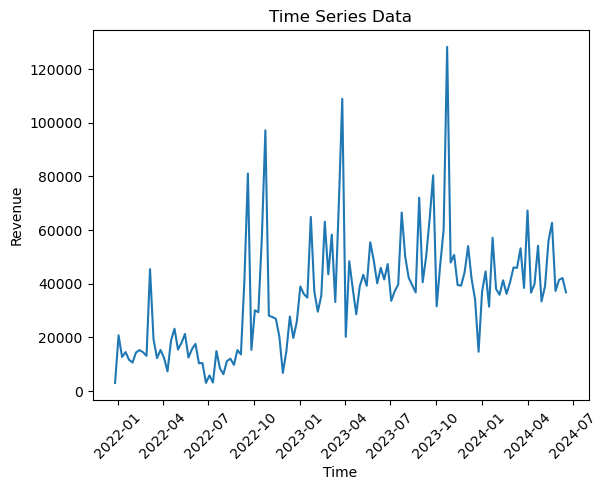

In [247]:
# prepare the time series data
customlevelpred = orders_subsets.sort_values(by="OrderDate")
# customlevelpred = customlevelpred.groupby('OrderDate')[['NetRevenue', 'Quantity']].sum().reset_index()
customlevelpred = customlevelpred.groupby('OrderDate')['NetRevenue'].sum().reset_index()
# aggregate on weekly basis
#customlevelpred = customlevelpred.groupby([pd.Grouper(key='OrderDate', freq='W-MON', label='left')])[['NetRevenue', 'Quantity']].sum().reset_index().sort_values('OrderDate')
customlevelpred = customlevelpred.groupby([pd.Grouper(key='OrderDate', freq='W-MON', label='left')])['NetRevenue'].sum().reset_index().sort_values('OrderDate')

# set date as indexing value for time series analyses such as ARIMA
#customlevelpred.set_index('OrderDate', inplace=True)
customlevelpred = customlevelpred[:130]
print(customlevelpred.head())
print(customlevelpred.info())

# plot the time series
plt.plot(customlevelpred["OrderDate"], customlevelpred["NetRevenue"])
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.xticks(rotation = 45)
plt.title('Time Series Data')
plt.show()

ADF Statistic: -2.3548882842341907
p-value: 0.1548755831197295
	1%: -3.483
	5%: -2.885
	10%: -2.579


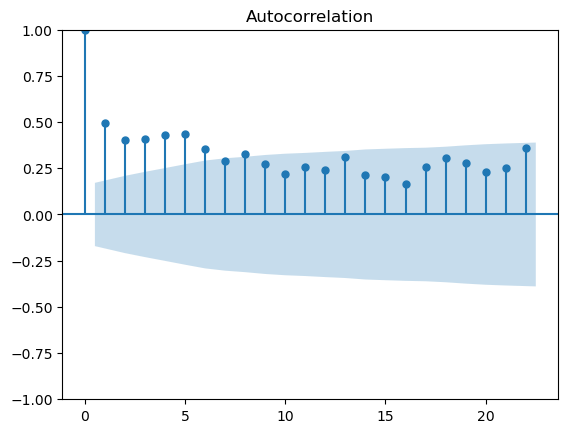

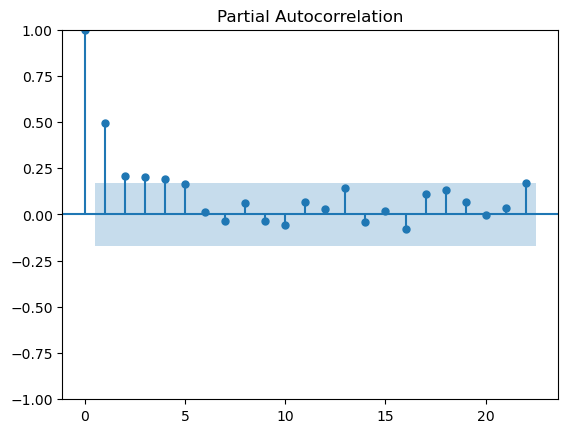

In [4]:
# USE THIS ONE for fitting on different functions
# TBD handle stationarity, trend, seasonality

# https://www.timescale.com/blog/how-to-work-with-time-series-in-python/
    
# test for stationarity
from statsmodels.tsa.stattools import adfuller
# Assuming 'data' is the time series data
result = adfuller(customlevelpred["NetRevenue"])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary
# TBD cluster 3 data: revenue is not stationary, rescale for better predictions

# test for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Assuming 'data' is the time series data
plot_acf(customlevelpred["NetRevenue"])
plot_pacf(customlevelpred["NetRevenue"])
plt.show()
# ACF are within 95% confidence interval = data doesn’t have any autocorrelation
# ACF outside of interval = autocorrelation
# TBD cluster 3 data: potential autocorrelation between lags 1 to 5, consider either before or during training

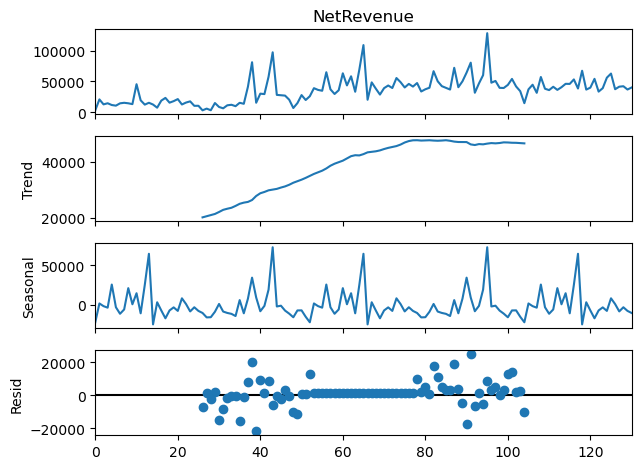

In [5]:
# TBD handle trend and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(customlevelpred["NetRevenue"], period = 52).plot()
#decompose_result.plot()

'from statsmodels.tsa.statespace.sarimax import SARIMAX\n\ndata1=customlevelpred["NetRevenue"]\n#data1.head()\ndata2 = customlevelpred["Quantity"]\nmodel = SARIMAX(data1, exog=data2,  enforce_stationarity=True,  order=(5, 2, 5))\ncustomlevelpred["SARIMAX"] = model.fit().fittedvalues\ncustomlevelpred[["NetRevenue","SARIMAX"]].plot(title="SARIMAX")'

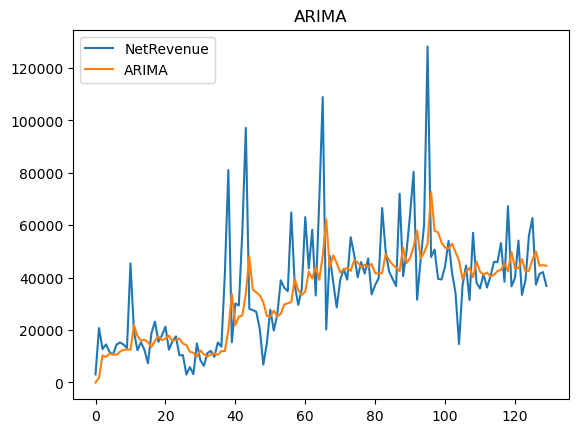

In [151]:
# customer level traditional prediction approaches

#import warnings
#warnings.filterwarnings("ignore")

# TBD further look into traditional time series analysis methods in addition to ML approaches below
# https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873

# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
customlevelpred["HWES1"] = SimpleExpSmoothing(customlevelpred["NetRevenue"]).fit().fittedvalues
customlevelpred[["NetRevenue","HWES1"]].plot(title="Holt Winters Single Exponential Smoothing")


# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
customlevelpred["HWES3_ADD"] = ExponentialSmoothing(customlevelpred["NetRevenue"],trend="add").fit().fittedvalues
customlevelpred["HWES3_MUL"] = ExponentialSmoothing(customlevelpred["NetRevenue"],trend="mul").fit().fittedvalues
customlevelpred[["NetRevenue","HWES3_ADD", "HWES3_MUL"]].plot(title="Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality")


# following code based on https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
# fit model
model = ARIMA(customlevelpred["NetRevenue"], order=(1, 1, 1))
customlevelpred["ARIMA"] = model_fit = model.fit().fittedvalues
customlevelpred[["NetRevenue","ARIMA"]].plot(title="ARIMA")
 
# SARIMAX example
# plots: best fitting
# TBD look into further optimization and potential predictions using SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

data1=customlevelpred["NetRevenue"]
#data1.head()
data2 = customlevelpred["Quantity"]
model = SARIMAX(data1, exog=data2,  enforce_stationarity=True,  order=(5, 2, 5))
customlevelpred["SARIMAX"] = model.fit().fittedvalues
customlevelpred[["NetRevenue","SARIMAX"]].plot(title="SARIMAX")

In [ ]:
customlevelpred['OrderDate'] = pd.to_datetime(customlevelpred['OrderDate'])
customlevelpred.set_index('OrderDate', inplace=True)
#print(customlevelpred)

# Fit the ARIMA model
model = ARIMA(customlevelpred["NetRevenue"], order=(5, 2, 5), seasonal_order=(0, 0, 0, 52), enforce_stationarity = True)
model_fit = model.fit()

# Forecast
forecast_steps = 26
forecast = model_fit.forecast(steps=forecast_steps)

# Create a DataFrame to hold the forecasted values
last_date = customlevelpred.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps, freq='W-MON')[1:]
forecast_df = pd.DataFrame(forecast, index=forecast_dates)

# Combine the original data with the forecast
#customlevelpred = pd.DataFrame(customlevelpred['NetRevenue'])
customlevelpred["ARIMA"] = model_fit.fittedvalues
combined_df = pd.concat([customlevelpred, forecast_df], axis=0)

# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df["NetRevenue"], label="Original Data")
plt.plot(customlevelpred.index, customlevelpred["ARIMA"], label="ARIMA Fitted Values")
plt.plot(combined_df.index, combined_df["predicted_mean"], label="Forecast", linestyle='dashed')
plt.title("2024 - Weekly ARIMA Forecast of Revenue for Customers in Cluster 3")
plt.xlabel("Date (weeks)")
plt.ylabel("Revenue")
plt.legend()
plt.show()

In [252]:
#combined_df.to_csv("2024predictionsCluster3ARIMA.csv")

In [251]:
combined_df

,NetRevenue,ARIMA,predicted_mean
2021-12-27,3061.350785,0.000000,NaN
2022-01-03,20784.907068,4254.533084,NaN
2022-01-10,12727.215969,23871.533249,NaN
2022-01-17,14527.650524,19415.694853,NaN
2022-01-24,11662.307592,20490.352909,NaN
...,...,...,...
2024-11-11,NaN,NaN,48123.934376
2024-11-18,NaN,NaN,50549.430785
2024-11-25,NaN,NaN,50883.548951
2024-12-02,NaN,NaN,48589.772737


In [253]:
# tbd scale to have comparisons

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Extract actual and predicted values
# Make sure to exclude the forecasted periods from evaluation
actual = combined_df.loc[combined_df['NetRevenue'].notna(), 'NetRevenue']
predicted = combined_df.loc[combined_df['NetRevenue'].notna(), 'ARIMA']

# Reshape the data to fit the scaler
actual_reshaped = actual.values.reshape(-1, 1)
predicted_reshaped = predicted.values.reshape(-1, 1)

# Fit the MinMaxScaler on the actual values
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(actual_reshaped)

# Transform both actual and predicted values
actual_scaled = scaler.transform(actual_reshaped)
predicted_scaled = scaler.transform(predicted_reshaped)

# Calculate metrics on the scaled values
mse = mean_squared_error(actual_scaled, predicted_scaled)
mae = mean_absolute_error(actual_scaled, predicted_scaled)


print(f'Mean Squared Error (MSE) on scaled data: {mse}')
print(f'Mean Absolute Error (MAE) on scaled data: {mae}')


Mean Squared Error (MSE) on scaled data: 0.018698769969589118
Mean Absolute Error (MAE) on scaled data: 0.09702146111931456


In [227]:
actual

,NetRevenue,ARIMA,predicted_mean
2021-12-27,6550.040576,0.000000,NaN
2022-01-03,21021.429319,8974.726196,NaN
2022-01-10,26732.985602,25975.170842,NaN
2022-01-17,29902.784031,34069.246363,NaN
2022-01-24,23850.312827,35970.518525,NaN
...,...,...,...
2023-11-20,4076.460733,11743.215440,NaN
2023-11-27,6571.947644,11474.237754,NaN
2023-12-04,6193.586387,7101.636234,NaN
2023-12-11,16215.890052,7252.559173,NaN


In [ ]:
# not needed anymore

# tbd make prediction SARIMAX
yhat = model_fit.get_prediction(start = "2024-01-01", end = "2024-12-01")# tbd exog variable??
print(yhat)



# tried random forest for time series analysis 
# but realized that this might not be suitable in our context because it does not consider the time aspect

# https://swngui.medium.com/python-tutorial-using-random-forest-for-sales-forecasting-bda61d79318e

from sklearn.ensemble import RandomForestRegressor

customlevelpred1 = customlevelpred[["OrderDate", "NetRevenue", "Quantity"]]
train_data, test_data = customlevelpred1.loc[customlevelpred1["OrderDate"] < "2024-01-01"], customlevelpred1.loc[customlevelpred1["OrderDate"] > "2024-01-01"]

train_data.info()
test_data.info()

# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(train_data.drop(['OrderDate','NetRevenue'], axis=1), train_data['NetRevenue'])

# Predict the sales for the testing data
predictions = rf.predict(test_data.drop(['OrderDate','NetRevenue'], axis=1))

# Calculate the root mean squared error (RMSE)
rmse = ((predictions - test_data['NetRevenue']) ** 2).mean() ** 0.5
print('Root Mean Squared Error: {:.2f}'.format(rmse))

# Plot the actual and predicted sales
plt.scatter(test_data['NetRevenue'], predictions)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.show()

In [6]:
# clean data for lstm if Arima models were run before
customlevelpred = customlevelpred.drop(["HWES1", "HWES3_ADD", "HWES3_MUL", "ARIMA", "SARIMAX"], axis = 1)
customlevelpred.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 0 to 130
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OrderDate   131 non-null    datetime64[ns]
 1   NetRevenue  131 non-null    float64       
 2   Quantity    131 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 4.1 KB


   OrderDate    NetRevenue
0 2021-12-27   3061.350785
1 2022-01-03  20784.907068
2 2022-01-10  12727.215969
3 2022-01-17  14527.650524
4 2022-01-24  11662.307592
<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 0 to 129
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   OrderDate   130 non-null    datetime64[ns]
 1   NetRevenue  130 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.0 KB
None


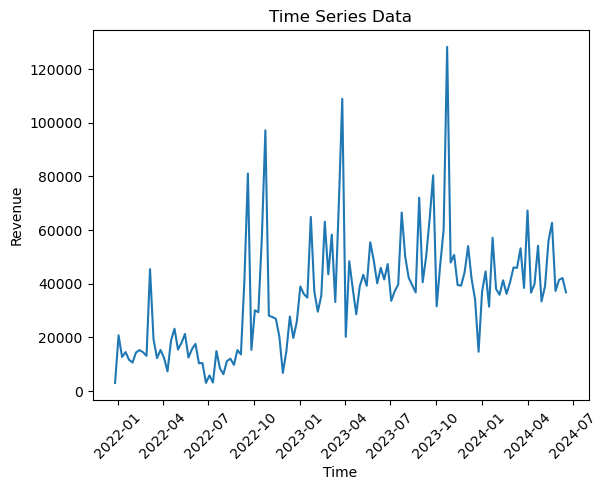

104 26


In [142]:
# LSTM for time series forecasting DONE
# fine tuning, optimal parameter DONE
# grid search DONE
# find ideal loss function, layer architecture, accuracy measures for time series in our context DONE
# TBD use additional input features for more information, ideas: orderCount, Quantities, different ArticleIDs aggregated on cluster level


# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# load packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# get input data and inspect to now basis
#lstmdatainput = customlevelpred.drop("Quantity", axis = 1)
lstmdatainput = customlevelpred
print(lstmdatainput.head())
print(lstmdatainput.info())

# plot the time series that is considered as input array
plt.plot(lstmdatainput["OrderDate"], lstmdatainput['NetRevenue'])
plt.xlabel('Time')
plt.ylabel('Revenue')
plt.xticks(rotation = 45)
plt.title('Time Series Data')
plt.show()


# random seed for reproducibility
tf.random.set_seed(5)

# transform integer into float for better handling in NN
dataframe = lstmdatainput["NetRevenue"]
dataset = dataframe.values
dataset = dataset.astype('float32')

#print(dataset)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

#print(dataset)

# create trainign and testing split
# TBD adapt to be split on 2022/2023 - 2024 (104 weeks training, 27 (of 2024) weeks testing)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

In [6]:
# function for creating the data input in LSTM format

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [143]:
# has to be rerun before every model training otherwise input format is messed up

# TBD find best lag (cf. autocorrelation displayed in lags 1 to 5)
# lag 2 already got better results than lag 1, find optimal one
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### grid search

In [33]:
# grid search to test combinations of parameters to find best settings
# takes a while to run with as many paramters to check, should not be necessary to rerun again

# reference https://blog.gopenai.com/how-to-perform-grid-search-hyperparameter-tuning-for-lstm-9bed04932d95

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Create the LSTM for grid search
def create_lstm_model(neurons=36, second_layer=12, loss='mean_absolute_error', activation='relu', optimizer='Adam', batch_size=12):
    model = Sequential()
    model.add(LSTM(units=neurons, activation=activation, input_shape=(1, look_back)))
    
    #if second_layer > 0: 
    #    model.add(LSTM(units=second_layer, return_sequences=False))
    
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])
    
    return model

# Wrap the custom wrapper function for use with scikit-learn
lstm_regressor = KerasRegressor(build_fn=create_lstm_model, epochs=50, batch_size=6, verbose=0)

# all parameter combinations to test
param_grid = {
    'optimizer': ['SGD', 'Adam'],
    'loss': ['mean_squared_error', 'mean_absolute_error', 'root_mean_squared_error', 'huber'],
    'batch_size': [1, 4, 6], # 12
    'epochs': [100, 250],
    'neurons': [12, 24],
    #'second_layer':[0, 12],  # 0 means no second LSTM layer
    'activation': ['relu', 'tanh'] #['relu', 'tanh', 'sigmoid', 'linear']
}

# run the grid search algorithm on the LSTM
grid_search = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=3)
grid_search_result = grid_search.fit(trainX, trainY)


In [59]:
# show the 10 best parameter sets
results_df = pd.DataFrame(grid_search_result.cv_results_)
top_params = results_df.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'mean_fit_time']]
pd.options.display.max_colwidth = 110
print(top_params)

#print(top_params.params)
#print(top_params.loc[1,"params"])

print("")
print("Best: %f using %s" % (grid_search_result.best_score_, grid_search_result.best_params_))
means = grid_search_result.cv_results_['mean_test_score']
stds = grid_search_result.cv_results_['std_test_score']
params = grid_search_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
#Best: -0.148562 using {'activation': 'relu', 'batch_size': 4, 'epochs': 250, 'loss': 'huber', 'neurons': 24, 'optimizer': 'Adam'}

                                                                                                            params  \
63     {'activation': 'relu', 'batch_size': 4, 'epochs': 250, 'loss': 'huber', 'neurons': 24, 'optimizer': 'Adam'}   
15     {'activation': 'relu', 'batch_size': 1, 'epochs': 100, 'loss': 'huber', 'neurons': 24, 'optimizer': 'Adam'}   
127    {'activation': 'tanh', 'batch_size': 1, 'epochs': 250, 'loss': 'huber', 'neurons': 24, 'optimizer': 'Adam'}   
29     {'activation': 'relu', 'batch_size': 1, 'epochs': 250, 'loss': 'huber', 'neurons': 12, 'optimizer': 'Adam'}   
51   {'activation': 'relu', 'batch_size': 4, 'epochs': 250, 'loss': 'mean_squared_error', 'neurons': 24, 'optim...   
31     {'activation': 'relu', 'batch_size': 1, 'epochs': 250, 'loss': 'huber', 'neurons': 24, 'optimizer': 'Adam'}   
7    {'activation': 'relu', 'batch_size': 1, 'epochs': 100, 'loss': 'mean_absolute_error', 'neurons': 24, 'opti...   
3    {'activation': 'relu', 'batch_size': 1, 'epochs': 1

### train model

in the following, different parameter settings are tested and evaluated on their prediction quality

basis: grid search proposed best parameter settings + literature search on LSTM parameter fine tuning

In [79]:
# option 1 from reference above

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
# TBD add second dense layer with more units? or pooling layer??
model.add(Dense(1))
# TBD choose best loss function 
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
93/93 - 3s - loss: 0.0319 - mse: 0.0319 - mae: 0.1211 - mape: 1295595.0000 - 3s/epoch - 29ms/step
Epoch 2/100
93/93 - 0s - loss: 0.0258 - mse: 0.0258 - mae: 0.1074 - mape: 1729736.2500 - 243ms/epoch - 3ms/step
Epoch 3/100
93/93 - 0s - loss: 0.0255 - mse: 0.0255 - mae: 0.1120 - mape: 1729363.7500 - 240ms/epoch - 3ms/step
Epoch 4/100
93/93 - 0s - loss: 0.0250 - mse: 0.0250 - mae: 0.1097 - mape: 1666294.5000 - 264ms/epoch - 3ms/step
Epoch 5/100
93/93 - 0s - loss: 0.0250 - mse: 0.0250 - mae: 0.1097 - mape: 1739856.1250 - 231ms/epoch - 2ms/step
Epoch 6/100
93/93 - 0s - loss: 0.0247 - mse: 0.0247 - mae: 0.1077 - mape: 1653399.3750 - 273ms/epoch - 3ms/step
Epoch 7/100
93/93 - 0s - loss: 0.0247 - mse: 0.0247 - mae: 0.1072 - mape: 1705360.3750 - 247ms/epoch - 3ms/step
Epoch 8/100
93/93 - 0s - loss: 0.0244 - mse: 0.0244 - mae: 0.1098 - mape: 1829413.3750 - 245ms/epoch - 3ms/step
Epoch 9/100
93/93 - 0s - loss: 0.0242 - mse: 0.0242 - mae: 0.1068 - mape: 1603098.5000 - 254ms/epoch - 3ms

Epoch 74/100
93/93 - 0s - loss: 0.0210 - mse: 0.0210 - mae: 0.1034 - mape: 1186700.0000 - 366ms/epoch - 4ms/step
Epoch 75/100
93/93 - 0s - loss: 0.0209 - mse: 0.0209 - mae: 0.1025 - mape: 1435613.6250 - 303ms/epoch - 3ms/step
Epoch 76/100
93/93 - 0s - loss: 0.0208 - mse: 0.0208 - mae: 0.1020 - mape: 1387202.5000 - 295ms/epoch - 3ms/step
Epoch 77/100
93/93 - 0s - loss: 0.0207 - mse: 0.0207 - mae: 0.1018 - mape: 1350546.6250 - 301ms/epoch - 3ms/step
Epoch 78/100
93/93 - 0s - loss: 0.0208 - mse: 0.0208 - mae: 0.1010 - mape: 1234897.6250 - 349ms/epoch - 4ms/step
Epoch 79/100
93/93 - 0s - loss: 0.0208 - mse: 0.0208 - mae: 0.1008 - mape: 1339445.1250 - 311ms/epoch - 3ms/step
Epoch 80/100
93/93 - 0s - loss: 0.0207 - mse: 0.0207 - mae: 0.1016 - mape: 1303958.7500 - 367ms/epoch - 4ms/step
Epoch 81/100
93/93 - 0s - loss: 0.0205 - mse: 0.0205 - mae: 0.1001 - mape: 1204312.3750 - 320ms/epoch - 3ms/step
Epoch 82/100
93/93 - 0s - loss: 0.0204 - mse: 0.0204 - mae: 0.0996 - mape: 1217637.2500 - 322ms/

In [81]:
# option 2 from reference but different loss function 

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
# check https://medium.com/@tpyrt1069098/there-are-14-loss-functions-for-regression-tasks-you-know-several-of-them-5ecd5e77a599
model.compile(loss='huber', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
93/93 - 2s - loss: 0.0342 - mse: 0.0683 - mae: 0.1870 - mape: 908859.6875 - 2s/epoch - 27ms/step
Epoch 2/100
93/93 - 0s - loss: 0.0163 - mse: 0.0326 - mae: 0.1233 - mape: 1954395.3750 - 252ms/epoch - 3ms/step
Epoch 3/100
93/93 - 0s - loss: 0.0149 - mse: 0.0298 - mae: 0.1227 - mape: 2099230.5000 - 243ms/epoch - 3ms/step
Epoch 4/100
93/93 - 0s - loss: 0.0144 - mse: 0.0287 - mae: 0.1205 - mape: 2053375.8750 - 252ms/epoch - 3ms/step
Epoch 5/100
93/93 - 0s - loss: 0.0142 - mse: 0.0284 - mae: 0.1189 - mape: 2084592.1250 - 244ms/epoch - 3ms/step
Epoch 6/100
93/93 - 0s - loss: 0.0140 - mse: 0.0280 - mae: 0.1173 - mape: 1979224.2500 - 244ms/epoch - 3ms/step
Epoch 7/100
93/93 - 0s - loss: 0.0138 - mse: 0.0277 - mae: 0.1164 - mape: 2019213.6250 - 253ms/epoch - 3ms/step
Epoch 8/100
93/93 - 0s - loss: 0.0135 - mse: 0.0270 - mae: 0.1154 - mape: 2051539.1250 - 261ms/epoch - 3ms/step
Epoch 9/100
93/93 - 0s - loss: 0.0133 - mse: 0.0266 - mae: 0.1137 - mape: 1867361.5000 - 243ms/epoch - 3ms/

Epoch 74/100
93/93 - 0s - loss: 0.0105 - mse: 0.0209 - mae: 0.1028 - mape: 1269563.0000 - 315ms/epoch - 3ms/step
Epoch 75/100
93/93 - 0s - loss: 0.0104 - mse: 0.0208 - mae: 0.1032 - mape: 1521131.0000 - 314ms/epoch - 3ms/step
Epoch 76/100
93/93 - 0s - loss: 0.0104 - mse: 0.0207 - mae: 0.1027 - mape: 1452821.3750 - 313ms/epoch - 3ms/step
Epoch 77/100
93/93 - 0s - loss: 0.0104 - mse: 0.0208 - mae: 0.1031 - mape: 1443888.0000 - 314ms/epoch - 3ms/step
Epoch 78/100
93/93 - 0s - loss: 0.0104 - mse: 0.0208 - mae: 0.1022 - mape: 1321556.5000 - 314ms/epoch - 3ms/step
Epoch 79/100
93/93 - 0s - loss: 0.0104 - mse: 0.0208 - mae: 0.1015 - mape: 1451939.1250 - 295ms/epoch - 3ms/step
Epoch 80/100
93/93 - 0s - loss: 0.0104 - mse: 0.0207 - mae: 0.1030 - mape: 1395752.3750 - 313ms/epoch - 3ms/step
Epoch 81/100
93/93 - 0s - loss: 0.0103 - mse: 0.0205 - mae: 0.1014 - mape: 1298701.3750 - 303ms/epoch - 3ms/step
Epoch 82/100
93/93 - 0s - loss: 0.0102 - mse: 0.0205 - mae: 0.1014 - mape: 1337145.8750 - 303ms/

In [144]:
# option 3 best parameters as proposed from grid search

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(24, activation='relu', input_shape=(1, look_back)))
# TBD add second dense layer with more units?
model.add(Dense(1))
model.compile(loss='huber', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=250, batch_size=4, verbose=2)

Epoch 1/250
24/24 - 2s - loss: 0.0366 - mse: 0.0732 - mae: 0.2048 - mape: 343699.0312 - 2s/epoch - 76ms/step
Epoch 2/250
24/24 - 0s - loss: 0.0201 - mse: 0.0402 - mae: 0.1370 - mape: 1008580.8125 - 67ms/epoch - 3ms/step
Epoch 3/250
24/24 - 0s - loss: 0.0136 - mse: 0.0272 - mae: 0.1039 - mape: 1555595.5000 - 64ms/epoch - 3ms/step
Epoch 4/250
24/24 - 0s - loss: 0.0123 - mse: 0.0245 - mae: 0.1091 - mape: 1657082.1250 - 68ms/epoch - 3ms/step
Epoch 5/250
24/24 - 0s - loss: 0.0122 - mse: 0.0243 - mae: 0.1077 - mape: 1658945.8750 - 59ms/epoch - 2ms/step
Epoch 6/250
24/24 - 0s - loss: 0.0122 - mse: 0.0243 - mae: 0.1051 - mape: 1611633.2500 - 71ms/epoch - 3ms/step
Epoch 7/250
24/24 - 0s - loss: 0.0122 - mse: 0.0243 - mae: 0.1092 - mape: 1734795.1250 - 73ms/epoch - 3ms/step
Epoch 8/250
24/24 - 0s - loss: 0.0120 - mse: 0.0239 - mae: 0.1087 - mape: 1744493.3750 - 63ms/epoch - 3ms/step
Epoch 9/250
24/24 - 0s - loss: 0.0119 - mse: 0.0239 - mae: 0.1063 - mape: 1664593.2500 - 73ms/epoch - 3ms/step
Epo

Epoch 75/250
24/24 - 0s - loss: 0.0076 - mse: 0.0151 - mae: 0.0880 - mape: 1115463.0000 - 76ms/epoch - 3ms/step
Epoch 76/250
24/24 - 0s - loss: 0.0074 - mse: 0.0148 - mae: 0.0874 - mape: 1120016.3750 - 80ms/epoch - 3ms/step
Epoch 77/250
24/24 - 0s - loss: 0.0075 - mse: 0.0149 - mae: 0.0886 - mape: 1093787.8750 - 81ms/epoch - 3ms/step
Epoch 78/250
24/24 - 0s - loss: 0.0073 - mse: 0.0146 - mae: 0.0868 - mape: 1081973.6250 - 72ms/epoch - 3ms/step
Epoch 79/250
24/24 - 0s - loss: 0.0072 - mse: 0.0144 - mae: 0.0871 - mape: 1106937.7500 - 71ms/epoch - 3ms/step
Epoch 80/250
24/24 - 0s - loss: 0.0073 - mse: 0.0145 - mae: 0.0860 - mape: 1041477.9375 - 75ms/epoch - 3ms/step
Epoch 81/250
24/24 - 0s - loss: 0.0072 - mse: 0.0144 - mae: 0.0850 - mape: 1015425.4375 - 67ms/epoch - 3ms/step
Epoch 82/250
24/24 - 0s - loss: 0.0071 - mse: 0.0142 - mae: 0.0861 - mape: 1049847.5000 - 75ms/epoch - 3ms/step
Epoch 83/250
24/24 - 0s - loss: 0.0071 - mse: 0.0142 - mae: 0.0878 - mape: 1110248.7500 - 72ms/epoch - 3

Epoch 149/250
24/24 - 0s - loss: 0.0058 - mse: 0.0117 - mae: 0.0803 - mape: 792530.1250 - 92ms/epoch - 4ms/step
Epoch 150/250
24/24 - 0s - loss: 0.0057 - mse: 0.0114 - mae: 0.0790 - mape: 822623.5000 - 88ms/epoch - 4ms/step
Epoch 151/250
24/24 - 0s - loss: 0.0056 - mse: 0.0112 - mae: 0.0775 - mape: 717716.6250 - 88ms/epoch - 4ms/step
Epoch 152/250
24/24 - 0s - loss: 0.0058 - mse: 0.0115 - mae: 0.0794 - mape: 682589.0625 - 89ms/epoch - 4ms/step
Epoch 153/250
24/24 - 0s - loss: 0.0056 - mse: 0.0112 - mae: 0.0779 - mape: 816207.2500 - 100ms/epoch - 4ms/step
Epoch 154/250
24/24 - 0s - loss: 0.0056 - mse: 0.0112 - mae: 0.0783 - mape: 821592.1875 - 87ms/epoch - 4ms/step
Epoch 155/250
24/24 - 0s - loss: 0.0056 - mse: 0.0113 - mae: 0.0788 - mape: 794312.3750 - 91ms/epoch - 4ms/step
Epoch 156/250
24/24 - 0s - loss: 0.0055 - mse: 0.0110 - mae: 0.0780 - mape: 862491.8750 - 85ms/epoch - 4ms/step
Epoch 157/250
24/24 - 0s - loss: 0.0056 - mse: 0.0112 - mae: 0.0788 - mape: 742172.5625 - 94ms/epoch - 

Epoch 223/250
24/24 - 0s - loss: 0.0047 - mse: 0.0095 - mae: 0.0719 - mape: 628506.6250 - 86ms/epoch - 4ms/step
Epoch 224/250
24/24 - 0s - loss: 0.0052 - mse: 0.0104 - mae: 0.0758 - mape: 779210.4375 - 83ms/epoch - 3ms/step
Epoch 225/250
24/24 - 0s - loss: 0.0048 - mse: 0.0096 - mae: 0.0713 - mape: 699358.1250 - 82ms/epoch - 3ms/step
Epoch 226/250
24/24 - 0s - loss: 0.0048 - mse: 0.0096 - mae: 0.0719 - mape: 726831.8125 - 82ms/epoch - 3ms/step
Epoch 227/250
24/24 - 0s - loss: 0.0049 - mse: 0.0098 - mae: 0.0733 - mape: 635151.6250 - 83ms/epoch - 3ms/step
Epoch 228/250
24/24 - 0s - loss: 0.0048 - mse: 0.0096 - mae: 0.0716 - mape: 602319.5000 - 91ms/epoch - 4ms/step
Epoch 229/250
24/24 - 0s - loss: 0.0050 - mse: 0.0100 - mae: 0.0736 - mape: 682804.6250 - 85ms/epoch - 4ms/step
Epoch 230/250
24/24 - 0s - loss: 0.0050 - mse: 0.0099 - mae: 0.0739 - mape: 638980.6250 - 92ms/epoch - 4ms/step
Epoch 231/250
24/24 - 0s - loss: 0.0048 - mse: 0.0095 - mae: 0.0711 - mape: 623614.5625 - 86ms/epoch - 4

In [85]:
# option 4 include dropouts for overfitting - better
from tensorflow.keras.layers import Dropout

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=250, batch_size=4, verbose=2)

Epoch 1/250
24/24 - 3s - loss: 0.0909 - mse: 0.0909 - mae: 0.2389 - mape: 183147.3906 - 3s/epoch - 143ms/step
Epoch 2/250
24/24 - 0s - loss: 0.0515 - mse: 0.0515 - mae: 0.1648 - mape: 1204517.3750 - 92ms/epoch - 4ms/step
Epoch 3/250
24/24 - 0s - loss: 0.0283 - mse: 0.0283 - mae: 0.1245 - mape: 2140684.5000 - 93ms/epoch - 4ms/step
Epoch 4/250
24/24 - 0s - loss: 0.0243 - mse: 0.0243 - mae: 0.1121 - mape: 2020238.5000 - 92ms/epoch - 4ms/step
Epoch 5/250
24/24 - 0s - loss: 0.0257 - mse: 0.0257 - mae: 0.1115 - mape: 2086203.7500 - 91ms/epoch - 4ms/step
Epoch 6/250
24/24 - 0s - loss: 0.0252 - mse: 0.0252 - mae: 0.1131 - mape: 1639316.6250 - 94ms/epoch - 4ms/step
Epoch 7/250
24/24 - 0s - loss: 0.0272 - mse: 0.0272 - mae: 0.1197 - mape: 2012722.3750 - 96ms/epoch - 4ms/step
Epoch 8/250
24/24 - 0s - loss: 0.0254 - mse: 0.0254 - mae: 0.1177 - mape: 2208213.2500 - 85ms/epoch - 4ms/step
Epoch 9/250
24/24 - 0s - loss: 0.0250 - mse: 0.0250 - mae: 0.1097 - mape: 1525343.2500 - 91ms/epoch - 4ms/step
Ep

Epoch 75/250
24/24 - 0s - loss: 0.0095 - mse: 0.0095 - mae: 0.0743 - mape: 896045.1875 - 122ms/epoch - 5ms/step
Epoch 76/250
24/24 - 0s - loss: 0.0118 - mse: 0.0118 - mae: 0.0802 - mape: 642344.7500 - 124ms/epoch - 5ms/step
Epoch 77/250
24/24 - 0s - loss: 0.0118 - mse: 0.0118 - mae: 0.0799 - mape: 803678.8750 - 131ms/epoch - 5ms/step
Epoch 78/250
24/24 - 0s - loss: 0.0127 - mse: 0.0127 - mae: 0.0788 - mape: 755555.5000 - 122ms/epoch - 5ms/step
Epoch 79/250
24/24 - 0s - loss: 0.0097 - mse: 0.0097 - mae: 0.0742 - mape: 744463.5625 - 121ms/epoch - 5ms/step
Epoch 80/250
24/24 - 0s - loss: 0.0122 - mse: 0.0122 - mae: 0.0801 - mape: 601576.7500 - 122ms/epoch - 5ms/step
Epoch 81/250
24/24 - 0s - loss: 0.0109 - mse: 0.0109 - mae: 0.0755 - mape: 1075609.7500 - 119ms/epoch - 5ms/step
Epoch 82/250
24/24 - 0s - loss: 0.0110 - mse: 0.0110 - mae: 0.0785 - mape: 1158282.3750 - 127ms/epoch - 5ms/step
Epoch 83/250
24/24 - 0s - loss: 0.0115 - mse: 0.0115 - mae: 0.0803 - mape: 625449.1875 - 132ms/epoch -

Epoch 148/250
24/24 - 0s - loss: 0.0090 - mse: 0.0090 - mae: 0.0728 - mape: 893567.0625 - 122ms/epoch - 5ms/step
Epoch 149/250
24/24 - 0s - loss: 0.0069 - mse: 0.0069 - mae: 0.0637 - mape: 1176218.3750 - 121ms/epoch - 5ms/step
Epoch 150/250
24/24 - 0s - loss: 0.0072 - mse: 0.0072 - mae: 0.0622 - mape: 1080129.3750 - 126ms/epoch - 5ms/step
Epoch 151/250
24/24 - 0s - loss: 0.0056 - mse: 0.0056 - mae: 0.0581 - mape: 650683.0000 - 127ms/epoch - 5ms/step
Epoch 152/250
24/24 - 0s - loss: 0.0067 - mse: 0.0067 - mae: 0.0624 - mape: 752506.1250 - 124ms/epoch - 5ms/step
Epoch 153/250
24/24 - 0s - loss: 0.0071 - mse: 0.0071 - mae: 0.0627 - mape: 663870.5625 - 128ms/epoch - 5ms/step
Epoch 154/250
24/24 - 0s - loss: 0.0056 - mse: 0.0056 - mae: 0.0587 - mape: 947056.0000 - 126ms/epoch - 5ms/step
Epoch 155/250
24/24 - 0s - loss: 0.0070 - mse: 0.0070 - mae: 0.0627 - mape: 1371762.8750 - 123ms/epoch - 5ms/step
Epoch 156/250
24/24 - 0s - loss: 0.0089 - mse: 0.0089 - mae: 0.0697 - mape: 584935.1875 - 123

Epoch 221/250
24/24 - 0s - loss: 0.0059 - mse: 0.0059 - mae: 0.0570 - mape: 894444.3125 - 122ms/epoch - 5ms/step
Epoch 222/250
24/24 - 0s - loss: 0.0051 - mse: 0.0051 - mae: 0.0529 - mape: 1164417.8750 - 118ms/epoch - 5ms/step
Epoch 223/250
24/24 - 0s - loss: 0.0077 - mse: 0.0077 - mae: 0.0579 - mape: 1071884.0000 - 122ms/epoch - 5ms/step
Epoch 224/250
24/24 - 0s - loss: 0.0064 - mse: 0.0064 - mae: 0.0620 - mape: 855984.6250 - 122ms/epoch - 5ms/step
Epoch 225/250
24/24 - 0s - loss: 0.0060 - mse: 0.0060 - mae: 0.0577 - mape: 1431976.1250 - 124ms/epoch - 5ms/step
Epoch 226/250
24/24 - 0s - loss: 0.0044 - mse: 0.0044 - mae: 0.0500 - mape: 641840.3125 - 130ms/epoch - 5ms/step
Epoch 227/250
24/24 - 0s - loss: 0.0045 - mse: 0.0045 - mae: 0.0503 - mape: 655732.2500 - 121ms/epoch - 5ms/step
Epoch 228/250
24/24 - 0s - loss: 0.0064 - mse: 0.0064 - mae: 0.0593 - mape: 665824.3750 - 121ms/epoch - 5ms/step
Epoch 229/250
24/24 - 0s - loss: 0.0042 - mse: 0.0042 - mae: 0.0473 - mape: 844491.1875 - 130

In [87]:
# option 5 tanh activation - worse
from tensorflow.keras.layers import Dropout

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=100, batch_size=4, verbose=2)

Epoch 1/100
24/24 - 5s - loss: 0.0688 - mse: 0.0688 - mae: 0.1931 - mape: 522692.0938 - 5s/epoch - 219ms/step
Epoch 2/100
24/24 - 0s - loss: 0.0268 - mse: 0.0268 - mae: 0.1131 - mape: 2090471.6250 - 111ms/epoch - 5ms/step
Epoch 3/100
24/24 - 0s - loss: 0.0252 - mse: 0.0252 - mae: 0.1165 - mape: 1916004.8750 - 112ms/epoch - 5ms/step
Epoch 4/100
24/24 - 0s - loss: 0.0249 - mse: 0.0249 - mae: 0.1112 - mape: 1655890.7500 - 111ms/epoch - 5ms/step
Epoch 5/100
24/24 - 0s - loss: 0.0251 - mse: 0.0251 - mae: 0.1097 - mape: 1895888.0000 - 115ms/epoch - 5ms/step
Epoch 6/100
24/24 - 0s - loss: 0.0248 - mse: 0.0248 - mae: 0.1105 - mape: 1584779.0000 - 121ms/epoch - 5ms/step
Epoch 7/100
24/24 - 0s - loss: 0.0269 - mse: 0.0269 - mae: 0.1174 - mape: 2056144.8750 - 111ms/epoch - 5ms/step
Epoch 8/100
24/24 - 0s - loss: 0.0240 - mse: 0.0240 - mae: 0.1116 - mape: 1962348.8750 - 112ms/epoch - 5ms/step
Epoch 9/100
24/24 - 0s - loss: 0.0262 - mse: 0.0262 - mae: 0.1105 - mape: 1309016.3750 - 119ms/epoch - 5ms

Epoch 74/100
24/24 - 0s - loss: 0.0243 - mse: 0.0243 - mae: 0.1119 - mape: 1511542.2500 - 142ms/epoch - 6ms/step
Epoch 75/100
24/24 - 0s - loss: 0.0214 - mse: 0.0214 - mae: 0.1023 - mape: 1380695.3750 - 143ms/epoch - 6ms/step
Epoch 76/100
24/24 - 0s - loss: 0.0212 - mse: 0.0212 - mae: 0.1048 - mape: 1382565.1250 - 152ms/epoch - 6ms/step
Epoch 77/100
24/24 - 0s - loss: 0.0210 - mse: 0.0210 - mae: 0.1035 - mape: 1307799.2500 - 151ms/epoch - 6ms/step
Epoch 78/100
24/24 - 0s - loss: 0.0231 - mse: 0.0231 - mae: 0.1062 - mape: 1116940.1250 - 150ms/epoch - 6ms/step
Epoch 79/100
24/24 - 0s - loss: 0.0200 - mse: 0.0200 - mae: 0.1011 - mape: 1401460.0000 - 154ms/epoch - 6ms/step
Epoch 80/100
24/24 - 0s - loss: 0.0233 - mse: 0.0233 - mae: 0.1069 - mape: 1254410.8750 - 150ms/epoch - 6ms/step
Epoch 81/100
24/24 - 0s - loss: 0.0227 - mse: 0.0227 - mae: 0.1054 - mape: 1074689.8750 - 151ms/epoch - 6ms/step
Epoch 82/100
24/24 - 0s - loss: 0.0213 - mse: 0.0213 - mae: 0.1011 - mape: 1125009.6250 - 151ms/

In [89]:
# option 6 include learning rate - looks better in plot, but slightly worse mape metric
import keras
from keras import layers

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=100, batch_size=4, verbose=2)

Epoch 1/100
24/24 - 3s - loss: 0.0387 - mse: 0.0387 - mae: 0.1536 - mape: 2591397.2500 - 3s/epoch - 131ms/step
Epoch 2/100
24/24 - 0s - loss: 0.0333 - mse: 0.0333 - mae: 0.1346 - mape: 2646226.5000 - 100ms/epoch - 4ms/step
Epoch 3/100
24/24 - 0s - loss: 0.0302 - mse: 0.0302 - mae: 0.1231 - mape: 2323012.7500 - 102ms/epoch - 4ms/step
Epoch 4/100
24/24 - 0s - loss: 0.0246 - mse: 0.0246 - mae: 0.1150 - mape: 2161660.0000 - 101ms/epoch - 4ms/step
Epoch 5/100
24/24 - 0s - loss: 0.0291 - mse: 0.0291 - mae: 0.1239 - mape: 2098232.0000 - 99ms/epoch - 4ms/step
Epoch 6/100
24/24 - 0s - loss: 0.0284 - mse: 0.0284 - mae: 0.1168 - mape: 1898482.1250 - 101ms/epoch - 4ms/step
Epoch 7/100
24/24 - 0s - loss: 0.0283 - mse: 0.0283 - mae: 0.1206 - mape: 1747844.8750 - 102ms/epoch - 4ms/step
Epoch 8/100
24/24 - 0s - loss: 0.0236 - mse: 0.0236 - mae: 0.1174 - mape: 2322115.5000 - 94ms/epoch - 4ms/step
Epoch 9/100
24/24 - 0s - loss: 0.0263 - mse: 0.0263 - mae: 0.1148 - mape: 1056723.6250 - 94ms/epoch - 4ms/s

Epoch 74/100
24/24 - 0s - loss: 0.0164 - mse: 0.0164 - mae: 0.0920 - mape: 268381.6250 - 124ms/epoch - 5ms/step
Epoch 75/100
24/24 - 0s - loss: 0.0185 - mse: 0.0185 - mae: 0.0954 - mape: 1129808.7500 - 122ms/epoch - 5ms/step
Epoch 76/100
24/24 - 0s - loss: 0.0148 - mse: 0.0148 - mae: 0.0843 - mape: 882442.6875 - 117ms/epoch - 5ms/step
Epoch 77/100
24/24 - 0s - loss: 0.0206 - mse: 0.0206 - mae: 0.0927 - mape: 1105874.7500 - 119ms/epoch - 5ms/step
Epoch 78/100
24/24 - 0s - loss: 0.0180 - mse: 0.0180 - mae: 0.0959 - mape: 1463852.2500 - 120ms/epoch - 5ms/step
Epoch 79/100
24/24 - 0s - loss: 0.0163 - mse: 0.0163 - mae: 0.0922 - mape: 727829.5625 - 129ms/epoch - 5ms/step
Epoch 80/100
24/24 - 0s - loss: 0.0208 - mse: 0.0208 - mae: 0.1033 - mape: 1086225.7500 - 129ms/epoch - 5ms/step
Epoch 81/100
24/24 - 0s - loss: 0.0148 - mse: 0.0148 - mae: 0.0863 - mape: 1524753.5000 - 125ms/epoch - 5ms/step
Epoch 82/100
24/24 - 0s - loss: 0.0199 - mse: 0.0199 - mae: 0.0984 - mape: 279958.7188 - 131ms/epoc

In [119]:
# option 7 increase dropouts for overfitting - worst of all of the above
from tensorflow.keras.layers import Dropout

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(1, look_back), return_sequences=True, dropout = 0.5))
#model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu', dropout = 0.5))
#model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=100, batch_size=4, verbose=2)

Epoch 1/100
25/25 - 3s - loss: 0.3781 - mse: 0.3781 - mae: 0.5734 - mape: 343366.5312 - 3s/epoch - 105ms/step
Epoch 2/100
25/25 - 0s - loss: 0.2531 - mse: 0.2531 - mae: 0.4595 - mape: 800469.9375 - 84ms/epoch - 3ms/step
Epoch 3/100
25/25 - 0s - loss: 0.0967 - mse: 0.0967 - mae: 0.2600 - mape: 2977747.5000 - 84ms/epoch - 3ms/step
Epoch 4/100
25/25 - 0s - loss: 0.0645 - mse: 0.0645 - mae: 0.2033 - mape: 2998732.5000 - 84ms/epoch - 3ms/step
Epoch 5/100
25/25 - 0s - loss: 0.0508 - mse: 0.0508 - mae: 0.1852 - mape: 4036331.2500 - 86ms/epoch - 3ms/step
Epoch 6/100
25/25 - 0s - loss: 0.0456 - mse: 0.0456 - mae: 0.1623 - mape: 6371222.0000 - 78ms/epoch - 3ms/step
Epoch 7/100
25/25 - 0s - loss: 0.0418 - mse: 0.0418 - mae: 0.1618 - mape: 5198816.5000 - 87ms/epoch - 3ms/step
Epoch 8/100
25/25 - 0s - loss: 0.0524 - mse: 0.0524 - mae: 0.1838 - mape: 3922587.5000 - 86ms/epoch - 3ms/step
Epoch 9/100
25/25 - 0s - loss: 0.0382 - mse: 0.0382 - mae: 0.1506 - mape: 5502281.5000 - 87ms/epoch - 3ms/step
Epo

Epoch 74/100
25/25 - 0s - loss: 0.0376 - mse: 0.0376 - mae: 0.1478 - mape: 5177508.5000 - 117ms/epoch - 5ms/step
Epoch 75/100
25/25 - 0s - loss: 0.0418 - mse: 0.0418 - mae: 0.1570 - mape: 4829031.5000 - 120ms/epoch - 5ms/step
Epoch 76/100
25/25 - 0s - loss: 0.0386 - mse: 0.0386 - mae: 0.1514 - mape: 4711343.5000 - 114ms/epoch - 5ms/step
Epoch 77/100
25/25 - 0s - loss: 0.0351 - mse: 0.0351 - mae: 0.1515 - mape: 4282636.5000 - 118ms/epoch - 5ms/step
Epoch 78/100
25/25 - 0s - loss: 0.0403 - mse: 0.0403 - mae: 0.1517 - mape: 4764044.0000 - 121ms/epoch - 5ms/step
Epoch 79/100
25/25 - 0s - loss: 0.0381 - mse: 0.0381 - mae: 0.1475 - mape: 5460781.5000 - 116ms/epoch - 5ms/step
Epoch 80/100
25/25 - 0s - loss: 0.0355 - mse: 0.0355 - mae: 0.1422 - mape: 5602817.5000 - 119ms/epoch - 5ms/step
Epoch 81/100
25/25 - 0s - loss: 0.0310 - mse: 0.0310 - mae: 0.1313 - mape: 4993760.5000 - 116ms/epoch - 5ms/step
Epoch 82/100
25/25 - 0s - loss: 0.0358 - mse: 0.0358 - mae: 0.1420 - mape: 5025809.0000 - 113ms/

In [91]:
# option 8 different dropouts for overfitting - better
from tensorflow.keras.layers import Dropout

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'mape'])
model.fit(trainX, trainY, epochs=100, batch_size=4, verbose=2)

Epoch 1/100
24/24 - 3s - loss: 0.0896 - mse: 0.0896 - mae: 0.2363 - mape: 255994.2188 - 3s/epoch - 134ms/step
Epoch 2/100
24/24 - 0s - loss: 0.0551 - mse: 0.0551 - mae: 0.1710 - mape: 1087741.1250 - 110ms/epoch - 5ms/step
Epoch 3/100
24/24 - 0s - loss: 0.0330 - mse: 0.0330 - mae: 0.1222 - mape: 1963221.5000 - 100ms/epoch - 4ms/step
Epoch 4/100
24/24 - 0s - loss: 0.0308 - mse: 0.0308 - mae: 0.1310 - mape: 2175087.2500 - 92ms/epoch - 4ms/step
Epoch 5/100
24/24 - 0s - loss: 0.0295 - mse: 0.0295 - mae: 0.1205 - mape: 1697249.5000 - 100ms/epoch - 4ms/step
Epoch 6/100
24/24 - 0s - loss: 0.0302 - mse: 0.0302 - mae: 0.1292 - mape: 1340937.1250 - 92ms/epoch - 4ms/step
Epoch 7/100
24/24 - 0s - loss: 0.0280 - mse: 0.0280 - mae: 0.1219 - mape: 2376380.5000 - 92ms/epoch - 4ms/step
Epoch 8/100
24/24 - 0s - loss: 0.0250 - mse: 0.0250 - mae: 0.1218 - mape: 2289155.0000 - 102ms/epoch - 4ms/step
Epoch 9/100
24/24 - 0s - loss: 0.0280 - mse: 0.0280 - mae: 0.1175 - mape: 1647958.5000 - 102ms/epoch - 4ms/st

Epoch 74/100
24/24 - 0s - loss: 0.0202 - mse: 0.0202 - mae: 0.0961 - mape: 1063276.7500 - 121ms/epoch - 5ms/step
Epoch 75/100
24/24 - 0s - loss: 0.0154 - mse: 0.0154 - mae: 0.0897 - mape: 998574.8750 - 117ms/epoch - 5ms/step
Epoch 76/100
24/24 - 0s - loss: 0.0194 - mse: 0.0194 - mae: 0.1020 - mape: 1694354.7500 - 122ms/epoch - 5ms/step
Epoch 77/100
24/24 - 0s - loss: 0.0151 - mse: 0.0151 - mae: 0.0897 - mape: 500869.0000 - 128ms/epoch - 5ms/step
Epoch 78/100
24/24 - 0s - loss: 0.0220 - mse: 0.0220 - mae: 0.1033 - mape: 1298904.2500 - 132ms/epoch - 6ms/step
Epoch 79/100
24/24 - 0s - loss: 0.0186 - mse: 0.0186 - mae: 0.0946 - mape: 1199875.0000 - 131ms/epoch - 5ms/step
Epoch 80/100
24/24 - 0s - loss: 0.0203 - mse: 0.0203 - mae: 0.1011 - mape: 1126911.3750 - 124ms/epoch - 5ms/step
Epoch 81/100
24/24 - 0s - loss: 0.0198 - mse: 0.0198 - mae: 0.1026 - mape: 719599.6250 - 122ms/epoch - 5ms/step
Epoch 82/100
24/24 - 0s - loss: 0.0163 - mse: 0.0163 - mae: 0.0904 - mape: 1410223.6250 - 119ms/epo

### predict future values based on trained model

In [145]:
# predict on given data
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

1/1 [==============================] - 0s 23ms/step
Train Score: 12036.71 RMSE
Test Score: 15553.57 RMSE


In [146]:
# predict future values

# Prepare the last sequence from the dataset
last_sequence = dataset[-look_back:]

# Initialize a list to store the predictions
future_predictions = []

# Iterate to predict
for _ in range(26):
    # Reshape the last sequence to the shape [samples, time steps, features]
    input_seq = np.reshape(last_sequence, (1, 1, look_back))
    
    # Predict the next value
    next_value = model.predict(input_seq)
    
    # Append the predicted value to the predictions list
    future_predictions.append(next_value[0, 0])
    
    # Update the last sequence by removing the first value and appending the predicted value
    last_sequence = np.append(last_sequence[1:], next_value)
    
    # Reshape back to (look_back,) for the next iteration
    last_sequence = last_sequence.reshape((look_back,))

# Convert predictions to a numpy array and scale back to the original scale
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_original_scale = scaler.inverse_transform(future_predictions)

# Print the future predictions in the original scale
print("Future Predictions:")
print(future_predictions_original_scale)

1/1 [==============================] - 0s 22ms/step
Future Predictions:
[[53501.266]
 [49383.76 ]
 [47425.02 ]
 [54958.594]
 [59159.297]
 [50186.668]
 [63083.773]
 [59131.227]
 [62012.543]
 [73973.3  ]
 [55129.277]
 [62994.277]
 [74648.35 ]
 [63030.83 ]
 [67757.05 ]
 [76454.47 ]
 [57802.844]
 [77179.98 ]
 [78815.86 ]
 [47989.95 ]
 [64833.82 ]
 [71694.836]
 [52767.227]
 [71235.79 ]
 [64630.383]
 [59928.09 ]]


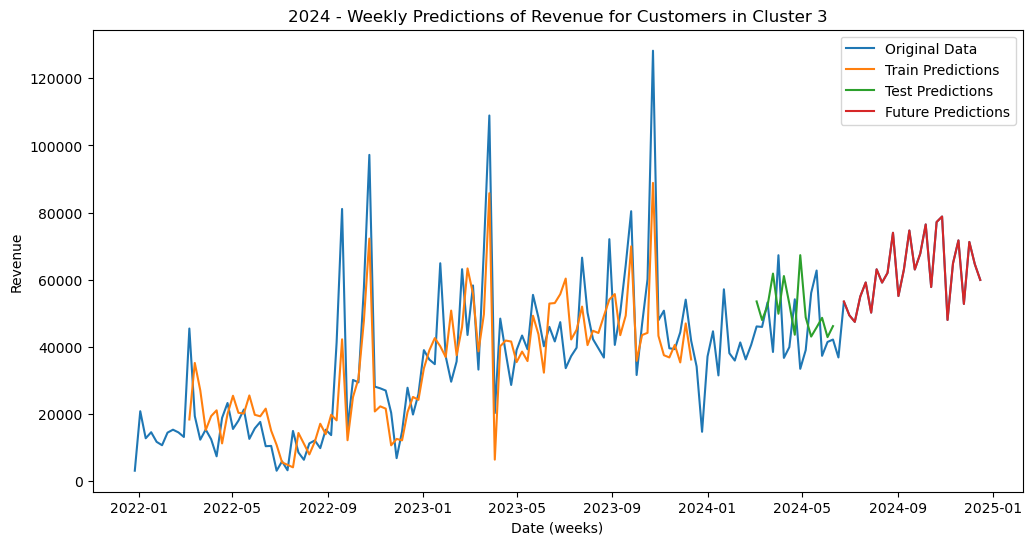

In [147]:
from datetime import timedelta

dates = lstmdatainput["OrderDate"]
last_date = dates.iloc[-1]
future_dates = [last_date + timedelta(weeks=i) for i in range(1, 27)]
future_dates = pd.to_datetime(future_dates, format='%Y-%m-%d')
# Combine original dates with future dates
extended_dates = pd.Series(np.concatenate([dates.values, future_dates]))
extended_dates = pd.to_datetime(extended_dates, format='%Y-%m-%d')

# Create a new array to hold the dataset including the future predictions
extended_dataset = np.append(dataset, future_predictions, axis=0)

# Inverse transform the extended dataset
extended_dataset_original_scale = scaler.inverse_transform(extended_dataset)

# Create an array to hold the future predictions for plotting
futurePredictPlot = np.empty_like(extended_dataset)
futurePredictPlot[:, :] = np.nan
futurePredictPlot[len(dataset):, :] = future_predictions_original_scale

# Shift train predictions for plotting
trainPredictPlot = np.empty_like(extended_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(extended_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Combine extended dataset with dates
extended_dataset_with_dates = pd.DataFrame({
    'Date': extended_dates,
    'Revenue': extended_dataset_original_scale.flatten(),
    'Train' : trainPredictPlot.flatten(),
    'Test' : testPredictPlot.flatten(),
    'Predict' : futurePredictPlot.flatten(),
})

# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(extended_dataset_with_dates["Date"], extended_dataset_with_dates["Revenue"], label='Original Data')
plt.plot(extended_dataset_with_dates["Date"], extended_dataset_with_dates["Train"], label='Train Predictions')
plt.plot(extended_dataset_with_dates["Date"], extended_dataset_with_dates["Test"], label='Test Predictions')
plt.plot(extended_dataset_with_dates["Date"], extended_dataset_with_dates["Predict"], label='Future Predictions')
plt.legend()
plt.title("2024 - Weekly Predictions of Revenue for Customers in Cluster 3")
plt.xlabel('Date (weeks)')
plt.ylabel('Revenue')
plt.show()

In [148]:
extended_dataset_with_dates.info()
filtered_extended_dataset_with_dates = extended_dataset_with_dates.dropna(subset=['Predict'])
filtered_extended_dataset_with_dates = filtered_extended_dataset_with_dates.drop(['Revenue','Train', 'Test'], axis=1)
filtered_extended_dataset_with_dates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     156 non-null    datetime64[ns]
 1   Revenue  156 non-null    float32       
 2   Train    93 non-null     float32       
 3   Test     15 non-null     float32       
 4   Predict  26 non-null     float32       
dtypes: datetime64[ns](1), float32(4)
memory usage: 3.8 KB


,Date,Predict
130,2024-06-24,53501.265625
131,2024-07-01,49383.761719
132,2024-07-08,47425.019531
133,2024-07-15,54958.593750
134,2024-07-22,59159.296875
135,2024-07-29,50186.667969
136,2024-08-05,63083.773438
137,2024-08-12,59131.226562
138,2024-08-19,62012.542969
139,2024-08-26,73973.296875


In [149]:
#extended_dataset_with_dates.to_csv("2024predictionsCluster3sample.csv")

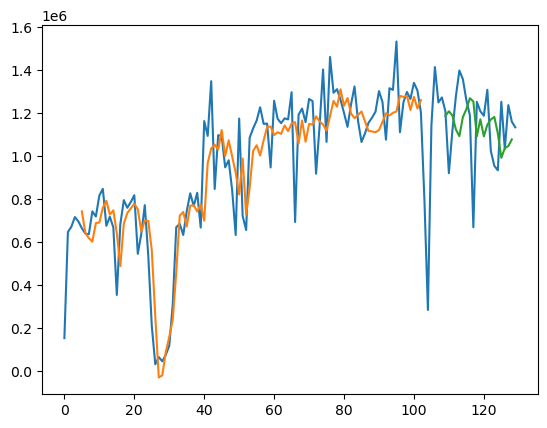

In [163]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [22]:
# proposed relevant datasets for dashboard
# customer-cluster assignments
# predictions for upcoming 6 months as dataframe

     CustomerID  cluster
362    10255544        2
571    10403731        2
629    10446652        2
660    10465952        2
1748     150085        2

   OrderDate    NetRevenue
0 2021-12-27   3061.350785
1 2022-01-03  20784.907068
2 2022-01-10  12727.215969
3 2022-01-17  14527.650524
4 2022-01-24  11662.307592

[[40825.246]
 [50121.38 ]
 [41858.62 ]
 [52709.746]
 [46157.89 ]
 [45872.492]
 [49109.125]
 [46092.684]
 [48680.23 ]
 [50243.508]
 [49964.188]
 [51289.08 ]
 [46590.5  ]
 [53914.34 ]
 [44794.445]
 [48293.91 ]
 [51784.863]
 [43844.97 ]
 [47306.305]
 [52181.86 ]
 [52234.82 ]
 [45398.805]
 [49176.777]
 [49328.08 ]]
